In [1]:
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
import os

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation, LeakyReLU
from tensorflow.keras import regularizers

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer

In [2]:
import tensorflow as tf

data_dir = "gs://emotional_model/WikiArtImages/WikiArtImages/"
file_pattern = data_dir + "*.png"  # Update file extension as necessary

image_count = len(tf.io.gfile.glob(file_pattern))
print(f"Found {image_count} images.")

Found 4119 images.


In [3]:
df = pd.read_csv("gs://emotional_model/6893Data/path_prob.csv")
df.head(3)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,happiness,/content/drive/My Drive/WikiArtImages/58c6237d...
1,1,577280dfedc2cb3880f28e76,anticipation,/content/drive/My Drive/WikiArtImages/577280df...
2,2,57727f2dedc2cb3880ed5fa9,happiness,/content/drive/My Drive/WikiArtImages/57727f2d...


In [4]:
df.emotion.value_counts()


happiness           1102
surprise             822
anticipation         520
trust                478
fear                 358
sadness              226
humility             184
love                 114
disgust              101
optimism              62
arrogance             52
anger                 36
gratitude             14
pessimism             10
shame                  7
disagreeableness       7
agreeableness          5
neutral                5
shyness                2
Name: emotion, dtype: int64

In [5]:
positive_emotions = ['gratitude', 'happiness', 'humility', 'love', 'optimism', 'trust']
negative_emotions = ['anger', 'arrogance', 'disgust', 'fear', 'pessimism', 'regret', 'sadness', 'shame']
mixed_emotions = ['agreeableness', 'anticipation', 'disagreeableness', 'shyness', 'surprise', 'neutral']

In [6]:
df["emotion"] = df.emotion.apply(lambda x: "positive" if (x in positive_emotions) \
                                 else ("negative" if x in negative_emotions else "mixed"))
df.head(5)


,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,positive,/content/drive/My Drive/WikiArtImages/58c6237d...
1,1,577280dfedc2cb3880f28e76,mixed,/content/drive/My Drive/WikiArtImages/577280df...
2,2,57727f2dedc2cb3880ed5fa9,positive,/content/drive/My Drive/WikiArtImages/57727f2d...
3,3,58d1240cedc2c94f900fc610,negative,/content/drive/My Drive/WikiArtImages/58d1240c...
4,4,57727de7edc2cb3880e91f26,positive,/content/drive/My Drive/WikiArtImages/57727de7...


In [7]:
df['path'] = df['path'].str.replace(
    '/content/drive/My Drive', 
    'gs://emotional_model/WikiArtImages', 
    regex=False
)

# Verify the changes
print(df.head())

   Unnamed: 0                        ID   emotion  \
0           0  58c6237dedc2c9c7dc0de1ae  positive   
1           1  577280dfedc2cb3880f28e76     mixed   
2           2  57727f2dedc2cb3880ed5fa9  positive   
3           3  58d1240cedc2c94f900fc610  negative   
4           4  57727de7edc2cb3880e91f26  positive   

                                                path  
0  gs://emotional_model/WikiArtImages/WikiArtImag...  
1  gs://emotional_model/WikiArtImages/WikiArtImag...  
2  gs://emotional_model/WikiArtImages/WikiArtImag...  
3  gs://emotional_model/WikiArtImages/WikiArtImag...  
4  gs://emotional_model/WikiArtImages/WikiArtImag...  


In [8]:
df.emotion.value_counts()

positive    1954
mixed       1361
negative     790
Name: emotion, dtype: int64

In [11]:
!pip install seaborn

/home/ecbm4040/envTF24/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


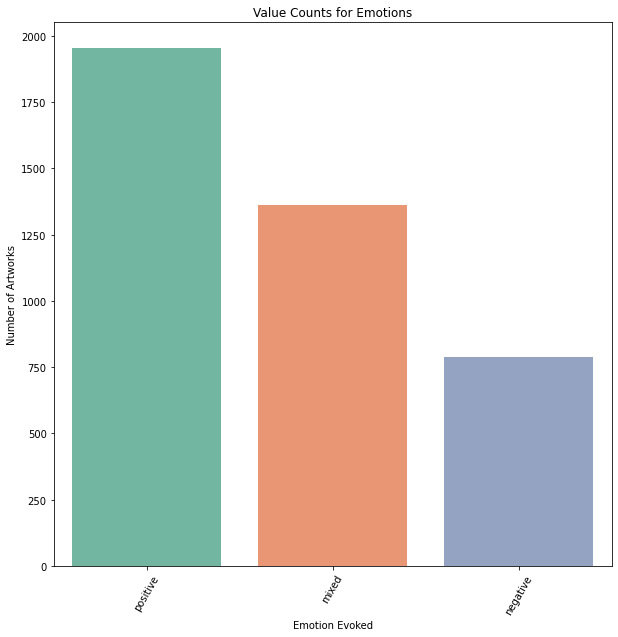

In [12]:
import seaborn as sns
emotion_3_class_count_plt = plt.figure(figsize=(10, 10))


sns.countplot(df.emotion, palette = "Set2")
plt.xlabel('Emotion Evoked')
plt.ylabel('Number of Artworks')
plt.xticks(rotation=60)
plt.title('Value Counts for Emotions')
plt.savefig("Value Counts for 3 Class.png", bbox_inches='tight', dpi = 250)
emotion_3_class_count_plt.savefig("Value Counts for 3 Class.png", bbox_inches='tight', dpi = 250)

## BaseLine

In [13]:
import tensorflow as tf

# Define training parameters
img_height = 224  # Image height
img_width = 224   # Image width
batch_size = 32
epochs = 100

# Convert labels to categorical format
emotions = pd.get_dummies(df['emotion']).values  # One-hot encoding
paths = df['path'].values

# Split datasets into train, validation, and test sets
val_set_start = int(0.6 * len(paths))
test_set_start = int(0.8 * len(paths))

train_paths = paths[:val_set_start]
train_labels = emotions[:val_set_start]

val_paths = paths[val_set_start:test_set_start]
val_labels = emotions[val_set_start:test_set_start]

test_paths = paths[test_set_start:]
test_labels = emotions[test_set_start:]

# Define a function to preprocess images without augmentation
def preprocess_image(path, label):
    # Read and decode the image
    file_bytes = tf.io.read_file(path)
    image = tf.io.decode_jpeg(file_bytes, channels=3)  # Ensure JPEG format
    # Resize and normalize the image
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(
    preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(
    preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(
    preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


In [14]:
model_tc_baseline = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile the model
model_tc_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:

# Calculate steps per epoch
steps_per_epoch = len(train_paths) // batch_size

# Train the model
history_tc_baseline = model_tc_baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            verbose=1,
            patience=4,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
25/25 [==============================] - 419s 17s/step - loss: 32.3067 - accuracy: 0.3583 - val_loss: 12.0570 - val_accuracy: 0.5213
Epoch 2/100
25/25 [==============================] - 461s 19s/step - loss: 7.6778 - accuracy: 0.4788 - val_loss: 3.5104 - val_accuracy: 0.3764
Epoch 3/100
25/25 [==============================] - 341s 14s/step - loss: 5.6977 - accuracy: 0.4213 - val_loss: 8.4246 - val_accuracy: 0.3678
Epoch 4/100
25/25 [==============================] - 148s 6s/step - loss: 5.3971 - accuracy: 0.4010 - val_loss: 4.6263 - val_accuracy: 0.3752


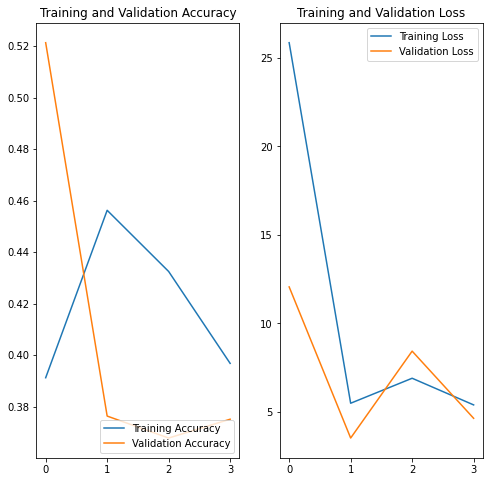

In [17]:
# Get the number of epochs the model ran
number_of_epochs_it_ran = len(history_tc_baseline .history['loss'])

# Extract metrics from the history object
acc = history_tc_baseline .history['accuracy']
val_acc = history_tc_baseline .history['val_accuracy']
loss = history_tc_baseline .history['loss']
val_loss = history_tc_baseline .history['val_loss']

# Create a range of epochs
epochs_range = range(number_of_epochs_it_ran)

# Plot Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the plots
plt.show()


In [18]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

0.4101705253124237

In [22]:
!nvidia-smi

Fri Dec 20 13:42:55 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |  14380MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
from tensorflow.keras import backend as K
import gc

K.clear_session()  # Clear TensorFlow session
gc.collect()

95

In [ ]:
!kill -9 3546

## Model: transfer Learning (MobileNet) + Data Augmentation


In [13]:
import tensorflow as tf
import tensorflow_addons as tfa

# Define training parameters
img_height = 224
img_width = 224
batch_size = 32

# Split the dataset
image_count = len(df)
val_set_start = int(0.6 * image_count)  # 60% for training
test_set_start = int(0.8 * image_count)  # 20% for validation, 20% for testing

# Function for augmentation (training only)
def augment_image(image):
    # Random rotation
    angle = tf.random.uniform([], -40 * 3.14159 / 180, 40 * 3.14159 / 180)
    image = tfa.image.rotate(image, angle)
    
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness and contrast
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    
    # Random zoom (cropping and resizing)
    crop_size = tf.cast([img_height * 0.8, img_width * 0.8], tf.int32)
    image = tf.image.random_crop(image, [crop_size[0], crop_size[1], 3])
    image = tf.image.resize(image, [img_height, img_width])
    
    return image

# Function to preprocess images (used for all datasets)
def decode_and_preprocess(path, label, training=True):
    # Read the file
    file_bytes = tf.io.read_file(path)
    # Decode the image
    image = tf.io.decode_image(file_bytes, channels=3, expand_animations=False)
    # Resize the image
    image = tf.image.resize(image, [img_height, img_width])
    # Normalize pixel values
    image = image / 255.0
    
    # Apply augmentation only during training
    if training:
        image = augment_image(image)
    
    return image, label


# With this
def encode_emotion(emotion):
    if emotion == 'positive':
        return 2
    elif emotion == 'negative':
        return 1
    else:  # mixed
        return 0
        
labels = df['emotion'].map(encode_emotion).values
paths = df['path'].values

train_paths = paths[:val_set_start]
train_labels = labels[:val_set_start]

val_paths = paths[val_set_start:test_set_start]
val_labels = labels[val_set_start:test_set_start]

test_paths = paths[test_set_start:]
test_labels = labels[test_set_start:]

# Create the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(
    lambda x, y: decode_and_preprocess(x, y, training=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(
    lambda x, y: decode_and_preprocess(x, y, training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(
    lambda x, y: decode_and_preprocess(x, y, training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [17]:
# Define image dimensions to match MobileNetV2 preferred size
img_height = 224
img_width = 224
batch_size = 32
epochs = 100

# Define MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Build the complete model - keeping the exact same structure
model_tc_mobilenet_aug_7 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model_tc_mobilenet_aug_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ensure labels are one-hot encoded
train_ds = train_ds.map(lambda x, y: (
    x, 
    tf.one_hot(tf.cast(y, tf.int32), depth=3)
))
val_ds = val_ds.map(lambda x, y: (
    x, 
    tf.one_hot(tf.cast(y, tf.int32), depth=3)
))

class_weights = {0: 1.,
                1: 1.,
                2: 2.}

history_tc_mobilenet_aug_7 = model_tc_mobilenet_aug_7.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            verbose=1,
            patience=20,
            restore_best_weights=True
        )
    ],
    class_weight=class_weights
)

Epoch 1/100
15/15 [==============================] - 842s 33s/step - loss: 0.8425 - accuracy: 0.5662 - val_loss: 0.6447 - val_accuracy: 0.6541
Epoch 2/100
15/15 [==============================] - 388s 28s/step - loss: 0.5977 - accuracy: 0.6890 - val_loss: 0.6602 - val_accuracy: 0.6541
Epoch 3/100
15/15 [==============================] - 359s 26s/step - loss: 0.5758 - accuracy: 0.6842 - val_loss: 0.5816 - val_accuracy: 0.7016
Epoch 4/100
15/15 [==============================] - 235s 17s/step - loss: 0.5491 - accuracy: 0.7150 - val_loss: 0.6119 - val_accuracy: 0.6955
Epoch 5/100
15/15 [==============================] - 265s 19s/step - loss: 0.5816 - accuracy: 0.7119 - val_loss: 0.6228 - val_accuracy: 0.6650
Epoch 6/100
15/15 [==============================] - 253s 18s/step - loss: 0.7293 - accuracy: 0.5412 - val_loss: 0.5879 - val_accuracy: 0.6979


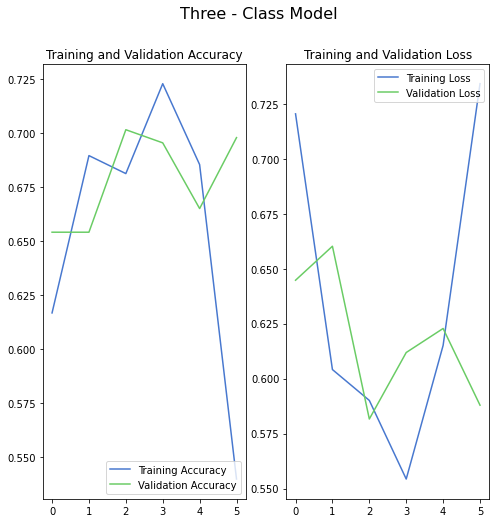

In [18]:
number_of_epochs_it_ran_7 = len(history_tc_mobilenet_aug_7.history['loss'])

acc_7 = history_tc_mobilenet_aug_7.history['accuracy']
val_acc_7 = history_tc_mobilenet_aug_7.history['val_accuracy']

loss_7 = history_tc_mobilenet_aug_7.history['loss']
val_loss_7 = history_tc_mobilenet_aug_7.history['val_loss']

epochs_range_7 = range(number_of_epochs_it_ran_7)

plt.style.use("seaborn-muted")
acc_plot_7 = plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_7, acc_7, label='Training Accuracy')
plt.plot(epochs_range_7, val_acc_7, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_7, loss_7, label='Training Loss')
plt.plot(epochs_range_7, val_loss_7, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

acc_plot_7.suptitle('Three - Class Model', fontsize=16)
acc_plot_7.show()

In [19]:
mean_acc_7 = sum(acc_7)/len(acc_7)
mean_acc_7

0.6559193134307861

In [20]:
mean_val_acc_7 = sum(val_acc_7)/len(val_acc_7)
mean_val_acc_7

0.6780349214871725

## Prediction & Evaluations

In [22]:
# import libraries for prediction/ evaluation & visualization
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import expand_dims
from tensorflow.keras.models import load_model

In [23]:
test_images = test_ds.map(lambda x, y: x)

# Predict using the model
predictions = model_tc_mobilenet_aug_7.predict(test_images)

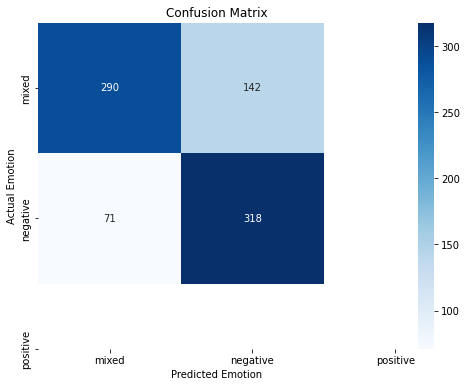


Classification Report:
              precision    recall  f1-score   support

       mixed       0.80      0.67      0.73       432
    negative       0.69      0.82      0.75       389
    positive       0.00      0.00      0.00         0

   micro avg       0.74      0.74      0.74       821
   macro avg       0.50      0.50      0.49       821
weighted avg       0.75      0.74      0.74       821


Prediction distribution:
{'mixed': 361, 'negative': 460}

Prediction Confidence:
Average confidence: 0.7216
Min confidence: 0.5003
Max confidence: 0.9908


/home/ecbm4040/envTF24/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ecbm4040/envTF24/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ecbm4040/envTF24/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ecbm4040/envTF24/lib/python3.6/si

In [24]:
# Map predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Define class names with all three classes
class_names = {0: 'mixed', 1: 'negative', 2: 'positive'}

# Convert predicted indices to emotion labels
predicted_emotions = [class_names[idx] for idx in predicted_class_indices]

# Get ground truth labels
y_ground_truth = np.concatenate([y for x, y in test_ds], axis=0)
# If labels are one-hot encoded, convert to class indices
if len(y_ground_truth.shape) > 1:
    y_ground_truth = np.argmax(y_ground_truth, axis=1)

# Create confusion matrix
confusion = confusion_matrix(y_ground_truth, predicted_class_indices)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.xlabel("Predicted Emotion")
plt.ylabel("Actual Emotion")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(
    y_ground_truth,
    predicted_class_indices,
    labels=[0, 1, 2],
    target_names=list(class_names.values())
))

# Print distribution of predictions
print("\nPrediction distribution:")
unique, counts = np.unique(predicted_class_indices, return_counts=True)
print(dict(zip([class_names[c] for c in unique], counts)))

# Print model confidence
prediction_confidence = np.max(predictions, axis=1)
print("\nPrediction Confidence:")
print(f"Average confidence: {np.mean(prediction_confidence):.4f}")
print(f"Min confidence: {np.min(prediction_confidence):.4f}")
print(f"Max confidence: {np.max(prediction_confidence):.4f}")